<a href="https://colab.research.google.com/gist/Ttemnaya/1f4617804c68f1dc542e9b6933c3d7ab/-_-_-_-_-_ipynb_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В ЭТОМ ФАЙЛЕ НАХОДИТСЯ:
1. БУСТИНГ ПАРАМЕТРОВ: МЕДЬ, АЛЮМИНИЙ, БИМ, ММВ, ВОЗМОЖНО - НЕФТЬ
2. ЗАПОЛНЕННАЯ ТАБЛИЦА ПРОГНОЗОВ ВСЕХ ПАРАМЕТРОВ.

ЗДЕСЬ НЕТ ПРОГНОЗА НА КОБАЛЬТ, МОЛИБДЕН И НИКЕЛЬ! У НИХ ЕСТЬ СОБСТВЕННЫЕ ФАЙЛЫ!

БИБЛИОТЕКИ

In [ ]:
from getpass import getpass
import os os.environ['Ttemnaya'] = getpass('Ttemnaya:') os.environ['GITHUB_TOKEN'] = getpass('GitHub token:')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame
import statsmodels.api as sm
import seaborn as sb
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
from matplotlib import pyplot
pd.options.display.float_format ='{:,.3f}'.format
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

ДОПОЛНИТЕЛЬНЫЕ ФУНКЦИИ

In [ ]:
def my_result(y_test, y_pred, title):
  # Оценка качества модели на тестовой выборке
  print(f"R^2 score: {r2_score(y_test, y_pred)}")

  # Расчет MSE и RMSE на тестовой выборке
  print("MSE на тестовой выборке:", mean_squared_error(y_test, y_pred))
  print("RMSE на тестовой выборке:", mean_squared_error(y_test, y_pred, squared=False))

  # визуализация прогноза модели
  plt.scatter(y_test, y_pred)
  plt.plot([0, y_test.max()], [0, y_pred.max()], 'k--', lw=2)
  plt.ylabel('Реальные значения')
  plt.xlabel('Предсказанные значения')
  plt.title(title)
  plt.show()

In [ ]:
def find_best_params(X_train, y_train, random_seed):
  # задаем параметры для поиска по сетке
  param_grid = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
              'max_depth': [2, 3, 4],
              'n_estimators': list(range(10, 200, 10)),
              'random_state' : [random_seed]}
  # создаем модель
  gb_model = GradientBoostingRegressor()

  # создаем объект GridSearchCV для поиска по сетке
  grid_search = GridSearchCV(gb_model, param_grid, cv=5)

  # обучаем модель
  grid_search.fit(X_train, y_train)

  return grid_search.best_params_

Полная таблица

In [ ]:
POLN=pd.read_excel('poln_param_bust.xlsx')
POLN['DATA'] = pd.to_datetime(POLN['DATA']).astype(int) // 10**9
POLN['DATA_log'] = np.log(POLN['DATA'])

POLN

,DATE,NEFT,MEDI,BIM,MMV,ALIM,DATA,DATA_log
0,2013-01-01,109.600,"8,115.260",154.010,95.197,"2,046.500",1356998400,21.029
1,2013-01-02,112.040,"8,272.890",159.330,96.652,"2,132.250",1357084800,21.029
2,2013-01-03,112.090,"8,115.260",159.610,96.517,"2,086.250",1357171200,21.029
3,2013-01-04,111.630,"8,159.350",155.630,96.214,"2,030.500",1357257600,21.029
4,2013-01-05,111.630,"8,159.350",155.630,96.214,"2,030.500",1357344000,21.029
...,...,...,...,...,...,...,...,...
3754,2023-04-13,61.260,"8,967.330",87.230,158.520,"2,363.000",1681344000,21.243
3755,2023-04-14,61.450,"9,094.110",87.140,159.370,"2,390.000",1681430400,21.243
3756,2023-04-15,61.450,"9,094.110",87.140,159.370,"2,390.000",1681516800,21.243
3757,2023-04-16,61.450,"9,065.440",87.140,159.370,"2,390.000",1681603200,21.243


In [ ]:
#Преобразования Сереги
POLN['DATE'] = pd.to_datetime(POLN['DATE'])

year = []
month = []
day = []
for i in range(len(POLN)):
  split_i = str(POLN['DATE'][i]).split()[0].split('-')
  year.append(int(split_i[0]))
  month.append(int(split_i[1]))
  day.append(int(split_i[2]))


POLN['year'] = year
POLN['month'] = month
POLN['day'] = day

# Cоздание признака "количество дней до конца квартала":
POLN['days_to_end_of_quarter'] = (pd.to_datetime(POLN['DATE'].dt.year.astype(str) + '-' + (((POLN['DATE'].dt.month - 1) // 3 + 1) * 3).astype(str) + '-01') + pd.DateOffset(months=3) - pd.DateOffset(days=1) - POLN['DATE']).dt.days

# Создание признака "количество дней до конца года":
POLN['days_to_end_of_year'] = (pd.to_datetime(POLN['DATE'].dt.year.astype(str) + '-12-31') - POLN['DATE']).dt.days

POLN['Weekday'] = POLN['DATE'].dt.weekday
POLN

,DATE,NEFT,MEDI,BIM,MMV,ALIM,DATA,DATA_log,year,month,day,days_to_end_of_quarter,days_to_end_of_year,Weekday
0,2013-01-01,109.600,"8,115.260",154.010,95.197,"2,046.500",1356998400,21.029,2013,1,1,150,364,1
1,2013-01-02,112.040,"8,272.890",159.330,96.652,"2,132.250",1357084800,21.029,2013,1,2,149,363,2
2,2013-01-03,112.090,"8,115.260",159.610,96.517,"2,086.250",1357171200,21.029,2013,1,3,148,362,3
3,2013-01-04,111.630,"8,159.350",155.630,96.214,"2,030.500",1357257600,21.029,2013,1,4,147,361,4
4,2013-01-05,111.630,"8,159.350",155.630,96.214,"2,030.500",1357344000,21.029,2013,1,5,146,360,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3754,2023-04-13,61.260,"8,967.330",87.230,158.520,"2,363.000",1681344000,21.243,2023,4,13,140,262,3
3755,2023-04-14,61.450,"9,094.110",87.140,159.370,"2,390.000",1681430400,21.243,2023,4,14,139,261,4
3756,2023-04-15,61.450,"9,094.110",87.140,159.370,"2,390.000",1681516800,21.243,2023,4,15,138,260,5
3757,2023-04-16,61.450,"9,065.440",87.140,159.370,"2,390.000",1681603200,21.243,2023,4,16,137,259,6


МЕДЬ ПРОГНОЗ - МОЛОДЕЦ 0,99

In [ ]:
#разбиваем на выборку
XK = POLN[['DATA',	'DATA_log',	'year',	'month',	'day', 'days_to_end_of_quarter',	'days_to_end_of_year', 'Weekday']]
yK = POLN['MEDI']

In [ ]:
XK_train, XK_test, yK_train, yK_test = train_test_split(XK, yK, test_size=0.3, random_state=40)

In [ ]:
# поиск параметрво для градиентного бустинга
random_seed2 = 70
params2 = find_best_params(XK_train, yK_train, random_seed2)

In [ ]:
params2 = {'learning_rate': 0.35, 'max_depth': 4, 'n_estimators': 190, 'random_state': 70}
modelK = GradientBoostingRegressor(**params2)
modelK.fit(XK_train, yK_train)
yK_pred = modelK.predict(XK_test)

R^2 score: 0.9967063609274979
MSE на тестовой выборке: 11988.046226435186
RMSE на тестовой выборке: 109.48993664458477


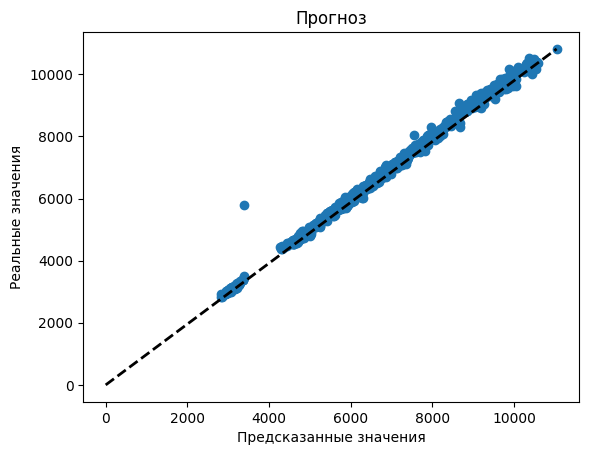

In [ ]:
title = 'Прогноз'
my_result(yK_test, yK_pred, title)

In [ ]:
#прогноз меди
y_future_MED = modelK.predict(pd.read_excel("predict.xlsx"))

In [ ]:
pd.DataFrame(y_future_MED).to_excel('prognos_MED.xlsx')

BIM МОЛОДЕЦ 0.99

In [ ]:
#разбиваем на выборку
XB = POLN[['DATA',	'DATA_log',	'year',	'month',	'day', 'days_to_end_of_quarter',	'days_to_end_of_year', 'Weekday']]
yB = POLN['BIM']

In [ ]:
XB_train, XB_test, yB_train, yB_test = train_test_split(XB, yB, test_size=0.3, random_state=40)

In [ ]:
# поиск параметрво для градиентного бустинга
random_seed3 = 70
params3 = find_best_params(XB_train, yB_train, random_seed3)


In [ ]:
params3 = {'learning_rate': 0.25, 'max_depth': 4, 'n_estimators': 190, 'random_state': 70}
modelB = GradientBoostingRegressor(**params3)
modelB.fit(XB_train, yB_train)
yB_pred = modelB.predict(XB_test)

R^2 score: 0.9967101363146859
MSE на тестовой выборке: 2.169713716839645
RMSE на тестовой выборке: 1.472994812224281


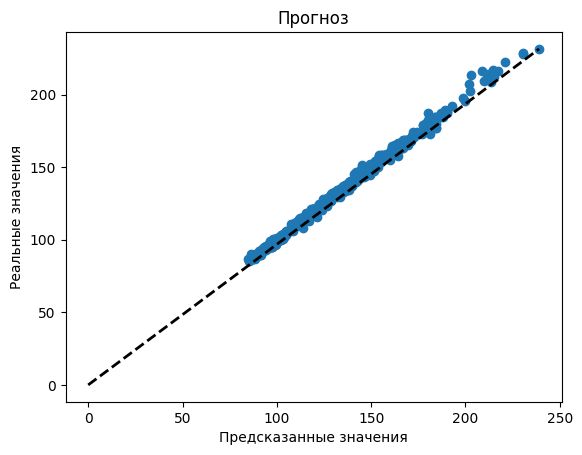

In [ ]:
title = 'Прогноз'
my_result(yB_test, yB_pred, title)

In [ ]:
#прогноз BIM
y_future_BIM = modelB.predict(pd.read_excel("predict.xlsx"))

In [ ]:
pd.DataFrame(y_future_BIM).to_excel('prognos_BIM.xlsx')

MMV 0.99

In [ ]:
#разбиваем на выборку
XM = POLN[['DATA',	'DATA_log',	'year',	'month',	'day', 'days_to_end_of_quarter',	'days_to_end_of_year', 'Weekday']]
yM = POLN['MMV']

In [ ]:
XM_train, XM_test, yM_train, yM_test = train_test_split(XM, yM, test_size=0.3, random_state=40)

In [ ]:
# поиск параметрво для градиентного бустинга
random_seed4 = 70
params4 = find_best_params(XM_train, yM_train, random_seed4)


In [ ]:
params4 = {'learning_rate': 0.35, 'max_depth': 4, 'n_estimators': 190, 'random_state': 70}
modelM = GradientBoostingRegressor(**params4)
modelM.fit(XM_train, yM_train)
yM_pred = modelM.predict(XM_test)

R^2 score: 0.9954900426702821
MSE на тестовой выборке: 3.5834552846331267
RMSE на тестовой выборке: 1.893001659965761


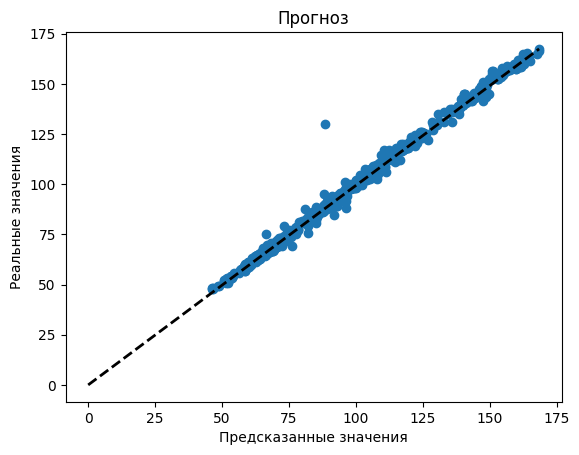

In [ ]:
title = 'Прогноз'
my_result(yM_test, yM_pred, title)

In [ ]:
#прогноз MMV
y_future_MMV = modelM.predict(pd.read_excel("predict.xlsx"))

In [ ]:
pd.DataFrame(y_future_MMV).to_excel('prognos_MMV.xlsx')

АЛЮМИНИЙ

In [ ]:
#разбиваем на выборку
XA = POLN[['DATA',	'DATA_log',	'year',	'month',	'day', 'days_to_end_of_quarter',	'days_to_end_of_year', 'Weekday']]
yA = POLN['ALIM']

In [ ]:
XA_train, XA_test, yA_train, yA_test = train_test_split(XA, yA, test_size=0.3, random_state=40)

In [ ]:
# поиск параметрво для градиентного бустинга
random_seed5 = 70
params5 = find_best_params(XA_train, yA_train, random_seed5)

In [ ]:
params5 = {'learning_rate': 0.35, 'max_depth': 4, 'n_estimators': 190, 'random_state': 70}
modelA = GradientBoostingRegressor(**params5)
modelA.fit(XM_train, yM_train)
yM_pred = modelM.predict(XM_test)

In [ ]:
title = 'Прогноз'
my_result(yM_test, yM_pred, title)

ОБЩАЯ ТАБЛИЦА СО ВСЕМИ ПАРАМЕТРАМИ НА ПОЛГОДА